In [ ]:
#!pip install tensorflow tensorflow_datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
(train_ds, test_ds), ds_info = tfds.load('plant_village', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
len(train_ds)

43442

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to fit VGG16 input
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

batch_size = 32

train_ds = train_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 277s 192ms/step - accuracy: 0.7504 - loss: 0.9352 - val_accuracy: 0.9087 - val_loss: 0.2814
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 250s 184ms/step - accuracy: 0.9406 - loss: 0.1762 - val_accuracy: 0.9246 - val_loss: 0.2327
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 210s 155ms/step - accuracy: 0.9603 - loss: 0.1180 - val_accuracy: 0.9298 - val_loss: 0.2383
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 250s 184ms/step - accuracy: 0.9700 - loss: 0.0893 - val_accuracy: 0.9360 - val_loss: 0.2418
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 251s 185ms/step - accuracy: 0.9727 - loss: 0.0780 - val_accuracy: 0.9271 - val_loss: 0.2755
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 210s 154ms/step - accuracy: 0.9801 - loss: 0.0557 - val_accuracy: 0.9322 - val_loss: 0.2852
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 302s 184ms/step - accuracy: 0.9810 - loss: 0.0557 - val_accuracy: 0.9174 - val_loss: 0.3666
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 262s 184ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Accuracy: {test_acc:.4f}')


340/340 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.9366 - loss: 0.3272
Test Accuracy: 0.9375


In [ ]:
# Example function to predict a single image
def predict_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = image / 255.0  # Normalize
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    return predicted_class

# Testing the prediction function with a batch from the test dataset
for image, label in test_ds.take(1):
    predicted_class = predict_image(image[0])
    print(f'Predicted class: {predicted_class}, True class: {label[0].numpy()}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 9, True class: 30


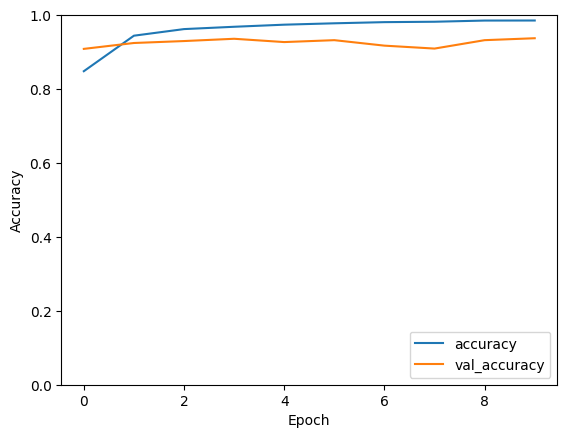

In [ ]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)
